In [62]:
from io import StringIO

import pandas as pd
from matplotlib import pyplot as plt

Reading the raw dataset.

In [63]:
json_array = "["
with open("../raw/webis_news_bias_20.json") as f:
    json_array += ",".join(line for line in f)
json_array += "]"

df = pd.read_json(StringIO(json_array))
df

,source,title,event_id,adfontes_fair,adfontes_political,allsides_bias,content,misc
0,Fox News,"Trump blasts Howard Schultz, says ex-Starbucks...",0,bias,bias,From the Right,Obama administration alum Roger Fisk and Repub...,"{'time': '2019-01-28 16:10:44.680484', 'topics..."
1,USA TODAY,Trump blasts former Starbucks CEO Howard Schul...,0,bias,neutral,From the Center,WASHINGTON – President Donald Trump took a swi...,"{'time': 'None', 'topics': 'Election: Presiden..."
2,Washington Times,Mick Mulvaney: Trump to secure border 'with or...,0,bias,neutral,From the Right,Acting White House chief of staff Mick Mulvane...,"{'time': 'None', 'topics': 'White House', 'aut..."
3,Washington Times,Trump says 'we'll do the emergency' if border ...,0,bias,neutral,From the Right,President Trump repeated his vow Friday to dec...,"{'time': 'None', 'topics': 'White House, Polit..."
4,BBC News,Trump backs down to end painful shutdown tempo...,0,bias,neutral,From the Center,President Donald Trump has yielded to politica...,"{'time': '2019-01-26 00:00:00', 'topics': 'Whi..."
...,...,...,...,...,...,...,...,...
7770,Politico,Ann Romney's task: Humanize Mitt,0,bias,neutral,From the Left,"TAMPA, Fla. — Ann Romney will take to the podi...","{'time': '2012-08-28 04:59:14', 'topics': 'Ele..."
7771,Washington Times,'Mittigator' to make case for Romney,0,bias,neutral,From the Right,"She is a gracious warrior with a kind face, a ...","{'time': 'None', 'topics': 'Election: Presiden..."
7772,Fox News,Convention-bound Ryan slams Obama for presidin...,0,bias,bias,From the Right,Republican VP pick on 'Special Report'\nMaking...,"{'time': '2012-08-27 00:00:00', 'topics': 'Ele..."
7773,Politico,Ryan seeks comfort of Ron Paul fans,0,bias,neutral,From the Left,Paul Ryan said Monday he expects Ron Paul supp...,"{'time': '2012-08-27 15:52:45', 'topics': 'Ele..."


Dropping useless columns.

In [64]:
df = df.drop(columns=["source", "event_id", "adfontes_fair", "adfontes_political", "misc"])

Renaming and reordering columns.

In [65]:
df = df.rename(columns={"content": "body", "allsides_bias": "leaning"})
df = df[["title", "body", "leaning"]].copy()

Categorizing the leaning column.

In [66]:
df["leaning"] = df["leaning"].astype("category")
df["leaning"] = df["leaning"].cat.rename_categories(
    {"From the Left": "left", "From the Center": "center", "From the Right": "right"}
)

Dropping rows with missing data.

In [56]:
df = df.dropna()

Printing duplicates.

In [67]:
df[df["body"].duplicated(keep=False)]

,title,body,leaning
14,Trump delays State of the Union Address until ...,WASHINGTON (Reuters) - U.S. President Donald T...,right
15,Trump delays State of the Union Address until ...,WASHINGTON (Reuters) - U.S. President Donald T...,center
133,Pelosi: ‘Open Discussion’ Whether Trump Can Be...,"Representative Nancy Pelosi (D., Calif.), who ...",right
134,Pelosi: ‘Open Discussion’ Whether Trump Can Be...,"Representative Nancy Pelosi (D., Calif.), who ...",left
197,"James Mattis quitting as defense secretary, ci...","Defense Secretary James Mattis, the last of a ...",right
...,...,...,...
7538,Last jobs report before election shows economy...,"Oct. 25, 2012: A sign attracts job-seekers dur...",right
7628,Romney Dominates In First Debate,"Who was that man, and what has he done with Mi...",right
7632,Romney Dominates In First Debate,"Who was that man, and what has he done with Mi...",right
7677,"'Fast and Furious' report slaps 14 at Justice,...",More than a dozen Justice Department and Burea...,left


Dropping the duplicates.

In [68]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [69]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head()

,title,body,leaning,body_length,body_word_count
4841,State Dept. spokeswoman sparks Twitter war wit...,(CNN),left,5,1
4890,President Obama Is Fired Up and Ready to Tweet,"— President Obama (@POTUS) May 18, 2015",left,39,7
4748,Donald Trump is showing a side of the GOP that...,Like this video? Subscribe to Vox on YouTube.\...,left,105,19
1957,Incredible New Year's Celebrations Around The ...,"From the London Eye to Athens’ Acropolis, here...",left,134,22
2553,Senate blocks Trump from making recess appoint...,The Senate blocked President Trump from being ...,center,144,22


After inspection, articles with bodies shorter than 30 words seem to contain no political value. Removing them.

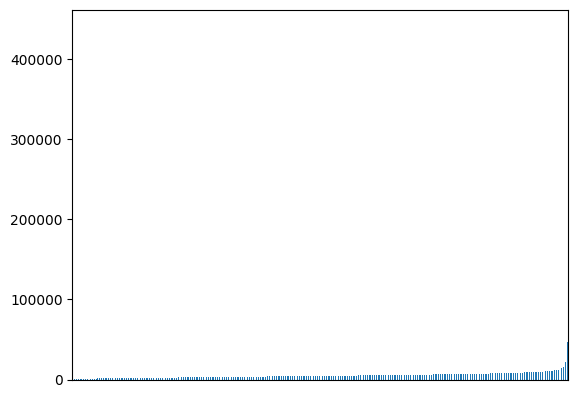

In [70]:
body_word_count_lower_bound = 30
df = df[df["body_word_count"] >= body_word_count_lower_bound]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df["body_length"].iloc[::10], df["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

In [71]:
df["body_length"].mean()

np.float64(5006.947811447812)

The leaning distribution.

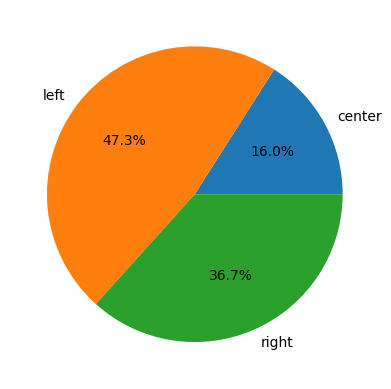

In [72]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

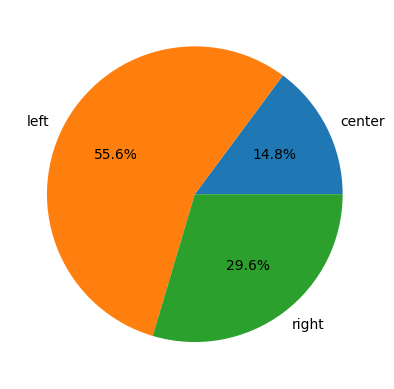

In [73]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution by leaning.

3656
2832
1234


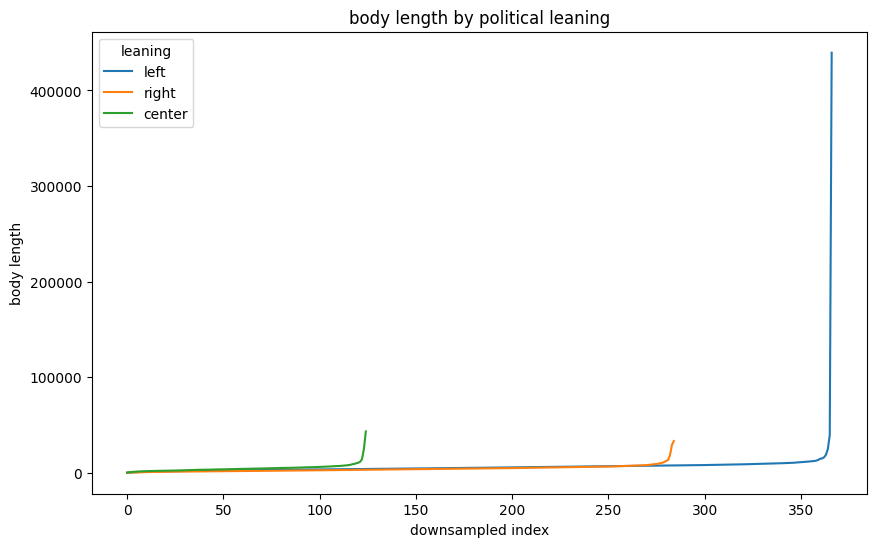

In [74]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::10], df_leaning["body_length"].tail(1)]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [75]:
df.to_parquet("../preprocessed/webis_news_bias_20.parquet")